In [1]:
#!pip install --upgrade --user sklearn


In [2]:
from __future__ import print_function
%run mp_utils.py
# Import libraries
import numpy as np
import pandas as pd
import sklearn
#import psycopg2
import sys
import datetime as dt
import mp_utils as mp

# to display dataframes in notebooks
from IPython.display import display, HTML

from collections import OrderedDict

# used to print out pretty pandas dataframes
#from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

# used to impute mean for data and standardize for computational stability
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier

# used to calculate AUROC/accuracy
from sklearn import metrics

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

#import matplotlib
#import matplotlib.pyplot as plt
#from matplotlib.font_manager import FontProperties # for unicode fonts
#%matplotlib inline

# below config used on pc70
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'


# two options for loading data
# option 1) use SQL - requires database and to have run queries/make_all.sql
# option 2) use CSVs downloaded
USE_SQL=0
USE_CSV=1

In [3]:
import gc 
gc.collect()

20

In [4]:
if USE_SQL:
    # Connect to local postgres version of mimic
    con = psycopg2.connect(dbname=dbname, user=sqluser)

    # exclusion criteria:
    #   - less than 15 years old
    #   - stayed in the ICU less than 4 hours
    #   - never have any chartevents data (i.e. likely administrative error)
    #   - organ donor accounts (administrative "readmissions" for patients who died in hospital)
    query = query_schema + \
    """
    select 
        *
    from dm_cohort
    """
    co = pd.read_sql_query(query,con)
    
    # convert the inclusion flags to boolean
    for c in co.columns:
        if c[0:10]=='inclusion_':
            co[c] = co[c].astype(bool)

    # extract static vars into a separate dataframe
    df_static = pd.read_sql_query(query_schema + 'select * from mp_static_data', con)
    #for dtvar in ['intime','outtime','deathtime']:
    #    df_static[dtvar] = pd.to_datetime(df_static[dtvar])

    vars_static = [u'is_male', u'emergency_admission', u'age',
                   # services
                   u'service_any_noncard_surg',
                   u'service_any_card_surg',
                   u'service_cmed',
                   u'service_traum',
                   u'service_nmed',
                   # ethnicities
                   u'race_black',u'race_hispanic',u'race_asian',u'race_other',
                   # phatness
                   u'height', u'weight', u'bmi']


    # get ~5 million rows containing data from errbody
    # this takes a little bit of time to load into memory (~2 minutes)

    # %%time results
    # CPU times: user 42.8 s, sys: 1min 3s, total: 1min 46s
    # Wall time: 2min 7s

    df = pd.read_sql_query(query_schema + 'select * from mp_data', con)
    df.drop('subject_id',axis=1,inplace=True)
    df.drop('hadm_id',axis=1,inplace=True)
    df.sort_values(['icustay_id','hr'],axis=0,ascending=True,inplace=True)

    # get death information
    df_death = pd.read_sql_query(query_schema + """
    select 
    co.subject_id, co.hadm_id, co.icustay_id
    , ceil(extract(epoch from (co.outtime - co.intime))/60.0/60.0) as dischtime_hours
    , ceil(extract(epoch from (adm.deathtime - co.intime))/60.0/60.0) as deathtime_hours
    , case when adm.deathtime is null then 0 else 1 end as death
    from dm_cohort co
    inner join admissions adm
    on co.hadm_id = adm.hadm_id
    where co.excluded = 0
    """, con)
    
    # get censoring information
    df_censor = pd.read_sql_query(query_schema + """
    select co.icustay_id, min(cs.charttime) as censortime
    , ceil(extract(epoch from min(cs.charttime-co.intime) )/60.0/60.0) as censortime_hours
    from dm_cohort co 
    inner join mp_code_status cs
    on co.icustay_id = cs.icustay_id
    where cmo+dnr+dni+dncpr+cmo_notes>0
    and co.excluded = 0
    group by co.icustay_id
    """, con)
    
    # extract static vars into a separate dataframe
    df_static = pd.read_sql_query(query_schema + 'select * from mp_static_data', con)
    
elif USE_CSV:
    co = pd.read_csv('data_compressed/df_cohort.csv.gz')
    
    # convert the inclusion flags to boolean
    for c in co.columns:
        if c[0:10]=='inclusion_':
            co[c] = co[c].astype(bool)
    df = pd.read_csv('data_compressed/df_data.csv.gz')
    df_static = pd.read_csv('data_compressed/df_static_data.csv.gz')
    df_censor = pd.read_csv('data_compressed/df_censor.csv.gz')
    df_death = pd.read_csv('data_compressed/df_death.csv.gz')
    
else:
    print('Must use SQL or CSV to load data!')
    
    
print(df.shape)

(6386894, 55)


# Base exclusion criteria

In [5]:
co = co.drop(co.columns[0], axis=1)
df = df.drop(df.columns[0], axis=1)
df_static=df_static.drop(df_static.columns[0], axis=1)
df_death = df_death.drop(df_death.columns[0], axis=1)
df_censor = df_censor.drop(df_censor.columns[0], axis=1)

In [6]:
# print out the exclusions *SEQUENTIALLY* - i.e. if already excluded, don't re-print
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))

idxRem = np.zeros(co.shape[0],dtype=bool)
for c in co.columns:
    if c[0:len('exclusion_')]=='exclusion_':
        N_REM = np.sum( (co[c].values==1) )
        print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
        idxRem[co[c].values==1] = True

# summarize all exclusions
N_REM = np.sum( idxRem )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], 'all exclusions'))
print('')
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
co = co.loc[~idxRem,:]

Cohort - initial size: 52085 ICU stays
      0 (0.00%) - exclusion_over_15
      0 (0.00%) - exclusion_valid_data
      0 (0.00%) - exclusion_stay_lt_4hr
      0 (0.00%) - exclusion_organ_donor
      0 (0.00%) - all exclusions

Final cohort size: 52085 ICU stays (100.00%).


## Mortality stats

### Mortality in base cohort

In [7]:
# mortality stats for base cohort
for c in co.columns:
    if c[0:len('death_')]=='death_':
        N_ALL = co.shape[0]
        N = co.set_index('icustay_id').loc[:,c].sum()
        print('{:40s}{:5g} of {:5g} died ({:2.2f}%).'.format(c, N, N_ALL, N*100.0/N_ALL))

death_48hr_post_icu_admit                1614 of 52085 died (3.10%).
death_icu                                4185 of 52085 died (8.03%).
death_in_hospital                        6192 of 52085 died (11.89%).
death_30dy_post_icu_admit                7567 of 52085 died (14.53%).
death_30dy_post_icu_disch                8081 of 52085 died (15.52%).
death_30dy_post_hos_disch                8633 of 52085 died (16.57%).
death_6mo_post_hos_disch                12788 of 52085 died (24.55%).
death_1yr_post_hos_disch                15052 of 52085 died (28.90%).
death_2yr_post_hos_disch                17758 of 52085 died (34.09%).
death_30dy_post_hos_admit                7124 of 52085 died (13.68%).


### Mortality in MIMIC-II patients staying >= 24 hours

This is mainly an example of how the `inclFcn` works. It derives from the cohort a boolean index of patients to retain in the dataset.

In [8]:
inclFcn = lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_stay_ge_24hr'],'icustay_id']

# mortality stats for base cohort
for c in co.columns:
    if c[0:len('death_')]=='death_':
        N_ALL = inclFcn(co).shape[0]
        N = co.set_index('icustay_id').loc[inclFcn(co),c].sum()
        print('{:40s}{:5g} of {:5g} died ({:2.2f}%).'.format(c, N, N_ALL, N*100.0/N_ALL))

death_48hr_post_icu_admit                 405 of 23497 died (1.72%).
death_icu                                2020 of 23497 died (8.60%).
death_in_hospital                        3034 of 23497 died (12.91%).
death_30dy_post_icu_admit                3613 of 23497 died (15.38%).
death_30dy_post_icu_disch                3933 of 23497 died (16.74%).
death_30dy_post_hos_disch                4212 of 23497 died (17.93%).
death_6mo_post_hos_disch                 6205 of 23497 died (26.41%).
death_1yr_post_hos_disch                 7362 of 23497 died (31.33%).
death_2yr_post_hos_disch                 8879 of 23497 died (37.79%).
death_30dy_post_hos_admit                3390 of 23497 died (14.43%).


Here we have the same function in a slightly more obscure way - with the benefit of being able to list all inclusions in a list. This just helps readability in the below code.

In [9]:
inclusions = ['inclusion_only_mimicii', 'inclusion_stay_ge_24hr']
inclFcn = lambda x: x.loc[x[inclusions].all(axis=1),'icustay_id']

# mortality stats for base cohort
for c in co.columns:
    if c[0:len('death_')]=='death_':
        N_ALL = inclFcn(co).shape[0]
        N = co.set_index('icustay_id').loc[inclFcn(co),c].sum()
        print('{:40s}{:5g} of {:5g} died ({:2.2f}%).'.format(c, N, N_ALL, N*100.0/N_ALL))

death_48hr_post_icu_admit                 405 of 23497 died (1.72%).
death_icu                                2020 of 23497 died (8.60%).
death_in_hospital                        3034 of 23497 died (12.91%).
death_30dy_post_icu_admit                3613 of 23497 died (15.38%).
death_30dy_post_icu_disch                3933 of 23497 died (16.74%).
death_30dy_post_hos_disch                4212 of 23497 died (17.93%).
death_6mo_post_hos_disch                 6205 of 23497 died (26.41%).
death_1yr_post_hos_disch                 7362 of 23497 died (31.33%).
death_2yr_post_hos_disch                 8879 of 23497 died (37.79%).
death_30dy_post_hos_admit                3390 of 23497 died (14.43%).


# Exclusion criteria

Each study has its own exclusion criteria (sometimes studies have multiple experiments). We define a dictionary of all exclusions with the dictionary key as the study name. Some studies have multiple experiments, so we append *a*, *b*, or *c*.

The dictionary stores a length 2 list. The first element defines the window for data extraction: it contains a dictionary of the windows and the corresponding window sizes. The second element is the exclusion criteria. Both are functions which use `co` or `df` as their input.

In [10]:
# first we can define the different windows: there aren't that many!
df_tmp=co.copy().set_index('icustay_id')

# admission+12 hours
time_12hr = df_tmp.copy()
time_12hr['windowtime'] = 12
time_12hr = time_12hr['windowtime'].to_dict()

# admission+24 hours
time_24hr = df_tmp.copy()
time_24hr['windowtime'] = 24
time_24hr = time_24hr['windowtime'].to_dict()

# admission+48 hours
time_48hr = df_tmp.copy()
time_48hr['windowtime'] = 48
time_48hr = time_48hr['windowtime'].to_dict()

# admission+72 hours
time_72hr = df_tmp.copy()
time_72hr['windowtime'] = 72
time_72hr = time_72hr['windowtime'].to_dict()

# admission+96 hours
time_96hr = df_tmp.copy()
time_96hr['windowtime'] = 96
time_96hr = time_96hr['windowtime'].to_dict()

# entire stay
time_all = df_tmp.copy()
time_all = time_all['dischtime_hours'].apply(np.ceil).astype(int).to_dict()

# 12 hours before the patient died/discharged
time_predeath = df_tmp.copy()
time_predeath['windowtime'] = time_predeath['dischtime_hours']
idx = time_predeath['deathtime_hours']<time_predeath['dischtime_hours']
time_predeath.loc[idx,'windowtime'] = time_predeath.loc[idx,'deathtime_hours']
# move from discharge/death time to 12 hours beforehand
time_predeath['windowtime'] = time_predeath['windowtime']-12
time_predeath = time_predeath['windowtime'].apply(np.ceil).astype(int).to_dict()

In [11]:
# example params used to extract patient data
# element 1: dictionary specifying end time of window for each patient
# element 2: size of window
# element 3: extra hours added to make it easier to get data on labs (and allows us to get labs pre-ICU)
# e.g. [time_24hr, 8, 24] is
#   (1) window ends at admission+24hr
#   (2) window is 8 hours long
#   (3) lab window is 8+24=32 hours long

def inclFcn(x, inclusions):
    return x.loc[x[inclusions].all(axis=1),'icustay_id']


# this one is used more than once, so we define it here
hugExclFcnMIMIC3 = lambda x: x.loc[x['inclusion_over_18']&x['inclusion_hug2009_obs']&x['inclusion_hug2009_not_nsicu_csicu']&x['inclusion_first_admission']&x['inclusion_full_code']&x['inclusion_not_brain_death']&x['inclusion_not_crf'],'icustay_id'].values
hugExclFcn = lambda x: np.intersect1d(hugExclFcnMIMIC3(x),x.loc[x['inclusion_only_mimicii'],'icustay_id'].values)


# physionet2012 subset - not exact but close
def physChallExclFcn(x):
    out = x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_stay_ge_48hr']&x['inclusion_has_saps'],'icustay_id'].values
    out = np.sort(out)
    out = out[0:4000]
    return out
 
# caballero2015 is a random subsample - then limits to 18yrs, resulting in 11648
def caballeroExclFcn(x):
    out = x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18'],'icustay_id'].values
    out = np.sort(out)
    out = out[0:11648]
    return out

np.random.seed(546345)
W_extra = 24

exclusions = OrderedDict([
['caballero2015dynamically_a',  [[time_24hr, 24, W_extra], caballeroExclFcn, 'hospital_expire_flag']],
['caballero2015dynamically_b',  [[time_48hr, 48, W_extra], caballeroExclFcn, 'hospital_expire_flag']],
['caballero2015dynamically_c',  [[time_72hr, 72, W_extra], caballeroExclFcn, 'hospital_expire_flag']],
['calvert2016computational',    [[time_predeath, 5, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_only_micu']&x['inclusion_calvert2016_obs']&x['inclusion_stay_ge_17hr']&x['inclusion_stay_le_500hr']&x['inclusion_non_alc_icd9'],'icustay_id'].values, 'hospital_expire_flag']],
['calvert2016using',            [[time_predeath, 5, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_only_micu']&x['inclusion_calvert2016_obs']&x['inclusion_stay_ge_17hr']&x['inclusion_stay_le_500hr'],'icustay_id'].values, 'hospital_expire_flag']],
['celi2012database_a',          [[time_72hr, 72, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_aki_icd9'],'icustay_id'].values , 'hospital_expire_flag']],
['celi2012database_b',          [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_sah_icd9'],'icustay_id'].values , 'hospital_expire_flag']],
['che2016recurrent_a',          [[time_48hr, 48, W_extra], lambda x: x.loc[x['inclusion_over_18'],'icustay_id'].values , 'death_48hr_post_icu_admit']],
['che2016recurrent_b',          [[time_48hr, 48, W_extra], physChallExclFcn , 'hospital_expire_flag']],
['ding2016mortality',           [[time_48hr, 48, W_extra], physChallExclFcn , 'hospital_expire_flag']],
['ghassemi2014unfolding_a',     [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_ge_100_non_stop_words']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'hospital_expire_flag']],
['ghassemi2014unfolding_b',     [[time_12hr, 12, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_ge_100_non_stop_words']&x['inclusion_stay_ge_12hr'],'icustay_id'].values, 'hospital_expire_flag']],
['ghassemi2014unfolding_c',     [[time_12hr, 12, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_ge_100_non_stop_words']&x['inclusion_stay_ge_12hr'],'icustay_id'].values, 'death_30dy_post_hos_disch']],
['ghassemi2014unfolding_d',     [[time_12hr, 12, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_ge_100_non_stop_words']&x['inclusion_stay_ge_12hr'],'icustay_id'].values, 'death_1yr_post_hos_disch']],
['ghassemi2015multivariate_a',    [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_ge_100_non_stop_words']&x['inclusion_gt_6_notes']&x['inclusion_stay_ge_24hr']&x['inclusion_has_saps'],'icustay_id'].values, 'hospital_expire_flag']],
['ghassemi2015multivariate_b',    [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_ge_100_non_stop_words']&x['inclusion_gt_6_notes']&x['inclusion_stay_ge_24hr']&x['inclusion_has_saps'],'icustay_id'].values, 'death_1yr_post_hos_disch']],
['grnarova2016neural_a',          [[time_all,  24, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_multiple_hadm'],'icustay_id'].values, 'hospital_expire_flag']],
['grnarova2016neural_b',          [[time_all,  24, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_multiple_hadm'],'icustay_id'].values, 'death_30dy_post_hos_disch']],
['grnarova2016neural_c',          [[time_all,  24, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_multiple_hadm'],'icustay_id'].values, 'death_1yr_post_hos_disch']],
['harutyunyan2017multitask',    [[time_48hr, 48, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_multiple_icustay'],'icustay_id'].values, 'hospital_expire_flag']],
['hoogendoorn2016prediction',   [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_hug2009_obs']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'hospital_expire_flag']],
['hug2009icu',                  [[time_24hr, 24, W_extra], hugExclFcn, 'death_30dy_post_icu_disch']],
['johnson2012patient',          [[time_48hr, 48, W_extra], physChallExclFcn, 'hospital_expire_flag']],
['johnson2014data',             [[time_48hr, 48, W_extra], physChallExclFcn, 'hospital_expire_flag']],
['joshi2012prognostic',         [[time_24hr, 24, W_extra], hugExclFcn, 'hospital_expire_flag']],
['joshi2016identifiable',       [[time_48hr, 48, W_extra], lambda x: x.loc[x['inclusion_over_18']&x['inclusion_stay_ge_48hr'],'icustay_id'].values, 'hospital_expire_flag']],
['lee2015customization_a',        [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_lee2015_service']&x['inclusion_has_saps']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'hospital_expire_flag']],
['lee2015customization_b',        [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_lee2015_service']&x['inclusion_has_saps']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'death_30dy_post_hos_disch']],
['lee2015customization_c',        [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_lee2015_service']&x['inclusion_has_saps']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'death_2yr_post_hos_disch']],
['lee2015personalized',         [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_has_saps']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'death_30dy_post_hos_disch']],
['lee2017patient',              [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_has_saps']&x['inclusion_stay_ge_24hr'],'icustay_id'].values, 'death_30dy_post_hos_disch']],
['lehman2012risk',              [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_has_saps']&x['inclusion_stay_ge_24hr']&x['inclusion_first_admission'],'icustay_id'].values, 'hospital_expire_flag']],
['luo2016interpretable_a',        [[time_all,  24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_has_sapsii']&x['inclusion_no_disch_summary'],'icustay_id'].values, 'death_30dy_post_hos_disch']],
['luo2016interpretable_b',        [[time_all,  24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_has_sapsii']&x['inclusion_no_disch_summary'],'icustay_id'].values, 'death_6mo_post_hos_disch']],
['luo2016predicting',           [[time_24hr, 12, W_extra], lambda x: np.intersect1d(hugExclFcn(x),x.loc[x['inclusion_stay_ge_24hr'],'icustay_id'].values) , 'death_30dy_post_icu_disch']],
['pirracchio2015mortality',     [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii'],'icustay_id'].values , 'hospital_expire_flag']],
['ripoll2014sepsis',            [[time_24hr, 24, W_extra], lambda x: x.loc[x['inclusion_only_mimicii']&x['inclusion_over_18']&x['inclusion_has_saps']&x['inclusion_not_explicit_sepsis'],'icustay_id'].values, 'hospital_expire_flag']],
['wojtusiak2017c',              [[time_all,  24, W_extra], lambda x: x.loc[x['inclusion_over_65']&x['inclusion_alive_hos_disch'],'icustay_id'].values, 'death_30dy_post_hos_disch']]
])

# Compare sample sizes and mortality rates

In [12]:
repro_stats = pd.DataFrame(None, columns=['N_Repro','Y_Repro'])

N = co.shape[0]
    
for current_study in exclusions:
    params, iid_keep, y_outcome_label = exclusions[current_study]
    
    # iid_keep is currently a function - apply it to co to get ICUSTAY_IDs to keep for this study
    iid_keep = iid_keep(co)
    
    N_STUDY = iid_keep.shape[0]
    Y_STUDY = co.set_index('icustay_id').loc[iid_keep,y_outcome_label].mean()*100.0
    
    # print size of cohort in study
    print('{:5g} ({:5.2f}%) - Mortality = {:5.2f}% - {}'.format(
            N_STUDY, N_STUDY*100.0/N, Y_STUDY,
            current_study)
         )
    
    repro_stats.loc[current_study] = [N_STUDY, Y_STUDY]
    

11648 (22.36%) - Mortality = 13.01% - caballero2015dynamically_a
11648 (22.36%) - Mortality = 13.01% - caballero2015dynamically_b
11648 (22.36%) - Mortality = 13.01% - caballero2015dynamically_c
 1985 ( 3.81%) - Mortality = 13.80% - calvert2016computational
18396 (35.32%) - Mortality = 14.71% - calvert2016using
 4741 ( 9.10%) - Mortality = 23.92% - celi2012database_a
 1070 ( 2.05%) - Mortality = 19.16% - celi2012database_b
51986 (99.81%) - Mortality =  3.10% - che2016recurrent_a
 4000 ( 7.68%) - Mortality = 14.35% - che2016recurrent_b
 4000 ( 7.68%) - Mortality = 14.35% - ding2016mortality
23442 (45.01%) - Mortality = 12.92% - ghassemi2014unfolding_a
28169 (54.08%) - Mortality = 12.20% - ghassemi2014unfolding_b
28169 (54.08%) - Mortality = 16.92% - ghassemi2014unfolding_c
28169 (54.08%) - Mortality = 29.76% - ghassemi2014unfolding_d
21969 (42.18%) - Mortality = 13.51% - ghassemi2015multivariate_a
21969 (42.18%) - Mortality = 32.35% - ghassemi2015multivariate_b
29572 (56.78%) - Mortalit

With the above dataframe, `repro_stats`, we can compare our results to those extracted manually from the studies. We load in the manual extraction from the `data` subfolder, merge it with this dataframe, and output to CSV.

In [13]:
study_data = pd.read_csv('../data/study_data.csv')
study_data.set_index('Cohort',inplace=True)
# add in reproduction sample size // outcome
study_data_merged = study_data.merge(repro_stats, how='left',
                left_index=True, right_index=True)


# print out the table as it was in the paper (maybe a bit more precision)
study_data_merged[ ['N_Study','N_Repro','Y_Study','Y_Repro'] ]

N_Study  N_Repro Y_Study    Y_Repro
Cohort                                                         
caballero2015dynamically_a    11648  11648.0       -  13.006525
caballero2015dynamically_b    11648  11648.0       -  13.006525
caballero2015dynamically_c    11648  11648.0       -  13.006525
calvert2016computational       3054   1985.0   12.84  13.803526
calvert2016using               9683  18396.0   10.68  14.709720
celi2012database_a             1400   4741.0    30.7  23.919004
celi2012database_b              223   1070.0    25.6  19.158879
che2016recurrent_a             4000  51986.0   13.85   3.095064
ding2016mortality              4000   4000.0   13.85  14.350000
ghassemi2014unfolding_a       19308  23442.0   10.84  12.916987
ghassemi2014unfolding_b       19308  28169.0   10.80  12.201356
ghassemi2015multivariate_a    10202  21969.0       -  13.514498
grnarova2016neural_a          31244  29572.0   13.82  12.494928
harutyunyan2017multitask      42276  45493.0       -  10.535687
hoogendoorn2016prediction     13923  17545.0       -  14.967227
johnson2012patient             4000   4000.0       -  14.350000
johnson2014data                4000   4000.0       -  14.350000
joshi2012prognostic           10066  10696.0    12.0   4.141735
lee2015customization_a        17490  20961.0   17.73  12.690234
lehman2012risk                14739  21738.0    14.6  12.319441
pirracchio2015mortality       24508  28795.0    12.2  12.720958
ripoll2014sepsis               2002   2251.0   21.10  39.626833
che2016recurrent_b            19714   4000.0     8.7  14.350000
hug2009icu                    10066  10696.0    17.0   6.348168
luo2016predicting              7863   8931.0    17.0   6.449446
joshi2016identifiable         17000  26508.0       -  14.950204
ghassemi2014unfolding_c       19308  28169.0    3.23  16.919308
grnarova2016neural_b          31244  29572.0    3.70  16.363452
lee2015personalized           17490  23443.0    15.1  17.941390
lee2015customization_b        17490  20961.0   23.56  17.861743
lee2017patient                17152  23443.0    15.1  17.941390
luo2016interpretable_a        18412  27747.0     3.4  17.054096
wojtusiak2017c                21651  22699.0     NaN   7.736024
luo2016interpretable_b        18412  27747.0     9.5  25.166685
ghassemi2014unfolding_d       19308  28169.0    3.34  29.756115
ghassemi2015multivariate_b    10202  21969.0       -  32.354682
grnarova2016neural_c          31244  29572.0   12.06  24.628027
lee2015customization_c        17152  20961.0  43.82   38.070703

# Define K-folds for AUROC comparison

In [14]:
# define var_static which is used later
#TODO: should refactor so this isn't needed
var_min, var_max, var_first, var_last, var_sum, var_first_early, var_last_early, var_static = mp.vars_of_interest()

K=5
np.random.seed(871)
# get unique subject_id (this is needed later)
sid = np.sort(np.unique(df_death['subject_id'].values))

# assign k-fold
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

# get indices which map subject_ids in sid to the X dataframe
idxMap = np.searchsorted(sid, df_death['subject_id'].values)

# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]

# Run results for a single study

The below code cell:

* extracts the cohort for a specific study
* extracts the outcome of that study
* builds predictive models in 5-fold cross-validation for that outcome

The two models at the moment are Gradient Boosting (xgboost) and logistic regression (scikit-learn).
This code cell only runs for one study.

In [15]:
# pick the study to run the example on
current_study = 'celi2012database_b'
    
# Rough timing info:
#     rf - 3 seconds per fold
#    xgb - 30 seconds per fold
# logreg - 4 seconds per fold
#  lasso - 8 seconds per fold
models = OrderedDict([
          ['xgb', xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)]#,
          #['lasso', LassoCV(cv=5,fit_intercept=True,normalize=True,max_iter=10000)],
          #['rf', RandomForestClassifier()],
          #['logreg', LogisticRegression(fit_intercept=True)]
         ])

print('')
print('====================={}==========='.format('='*len(current_study)))
print('========== BEGINNING {}==========='.format(current_study))
print('====================={}==========='.format('='*len(current_study)))

params = exclusions[current_study][0]
list(params[0].items())
#type(params[0])
#params[0]
#list(params[0])
np.asarray(list(params[0].items())).astype(int)



========== BEGINNING celi2012database_b===========


array([[200001,     24],
       [200003,     24],
       [200006,     24],
       ...,
       [299995,     24],
       [299998,     24],
       [299999,     24]])

In [16]:
params = exclusions[current_study][0]

In [17]:
#params[0].items()

In [23]:
current_study = 'celi2012database_b'
    
import warnings
warnings.filterwarnings("ignore")
    
# Rough timing info:
#     rf - 3 seconds per fold
#    xgb - 30 seconds per fold
# logreg - 4 seconds per fold
#  lasso - 8 seconds per fold
models = OrderedDict([
          ['xgb', xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05,n_jobs=1)],
          #['lasso', LassoCV(cv=5,fit_intercept=True,normalize=True,max_iter=10000)],
          #['rf', RandomForestClassifier()],
          #['logreg', LogisticRegression(fit_intercept=True)]
         ])

print('')
print('====================={}==========='.format('='*len(current_study)))
print('========== BEGINNING {}==========='.format(current_study))
print('====================={}==========='.format('='*len(current_study)))

params = exclusions[current_study][0]

df_data = mp.get_design_matrix(df, params[0], W=24, W_extra=24)

# get a list of icustay_id who stayed at least 12 hours
iid_keep = exclusions[current_study][1](co)
iid_keep =iid_keep[(iid_keep!=221538) &  (iid_keep!=277958)]
print('Reducing sample size from {} to {} ({:2.2f}%).'.format(
        df_data.shape[0], iid_keep.shape[0], iid_keep.shape[0]*100.0 / df_data.shape[0]))

df_data = df_data.loc[iid_keep,:]
print('')

y_outcome_label = exclusions[current_study][2]

# load the data into a numpy array

# first, the data from static vars from df_static
X = df_data.merge(df_static.set_index('icustay_id')[var_static], how='left', left_index=True, right_index=True)

# next, add in the outcome: death in hospital
X = X.merge(co.set_index('icustay_id')[[y_outcome_label]], left_index=True, right_index=True)

# map above K-fold indices to this dataset
X = X.merge(co.set_index('icustay_id')[['subject_id']], left_index=True, right_index=True)
# get indices which map subject_ids in sid to the X dataframe

idxMap = np.searchsorted(sid, X['subject_id'].values)
# use these indices to map the k-fold integers
idxK = idxK_sid[idxMap]
# drop the subject_id column
X.drop('subject_id',axis=1,inplace=True)
columns =(X.columns)
# convert to numpy data (assumes target, death, is the last column)
X = X.values
y = X[:,-1]
X = X[:,0:-1]
X_header = [x for x in df_data.columns.values] + var_static

mdl_val = dict()
results_val = dict()
pred_val = dict()
tar_val = dict()

for mdl in models:
    print('=============== {} ==============='.format(mdl))
    mdl_val[mdl] = list()
    results_val[mdl] = list() # initialize list for scores
    pred_val[mdl] = list()
    tar_val[mdl] = list()
    

    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", SimpleImputer(missing_values=np.nan,
                                          strategy="mean")),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])]) 

    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = estimator.fit(X[idxK != k, :],y[idxK != k])

        # get prediction on this dataset
        if mdl == 'lasso':
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]

        pred_val[mdl].append(curr_prob)
        tar_val[mdl].append(y[idxK == k])

        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_val[mdl].append(curr_score)

        # save the current model
        mdl_val[mdl].append(curr_mdl)

        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))


========== BEGINNING celi2012database_b===========
Reducing sample size from 52050 to 1068 (2.05%).

=============== xgb ===============
[21:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2021-05-24 21:24:26.508172 - Finished fold 1 of 5. AUROC 0.903.
[21:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2021-05-24 21:24:27.685175 - Finished fold 2 of 5. AUROC 0.961.
[21:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in 

In [24]:
#models
#mdl_val
#results_val
#df_data.to_csv("/Users/48501/Documents/GitHub/projekt_interdyscyplinarny_arimr/WB2_RashomonML/full_data.csv")
curr_mdl

Pipeline(memory=None,
         steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=1, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=True, validate_parameters=1,
                               verbosity=None))],
 

In [90]:
gc.collect()


20

# Rashomon
Od tego mementu zaczyna się zadanie 

In [92]:
X_t = pd.DataFrame(X)
X_t.columns = columns[0:-1]
X_t = X_t.reset_index()
X_t = X_t.iloc[:,1:]
y = y
import gc


In [93]:
# Kod do wczytania csv

from sklearn.model_selection import RandomizedSearchCV

parameters = {'xgb__n_estimators' : list(range(1,5000,250)),
              'xgb__learning_rate' : [2**x for x in range(-10,0,1)],
              'xgb__subsample' : [x/10 for x in range(1,11)],
              'xgb__max_depth' : list(range(1,16)),
              'xgb__min_child_weight' : [2**x for x in range(0,8)],
              #'xgb__colsample_bytree' : [0.1,0.5],
              'xgb__colsample_bylevel' : [x/10 for x in range(0,11)],
              'xgb__reg_lambda' : [2**x for x in range(-10,11)],
              'xgb__reg_alpha' : [2**x for x in range(-10,11)]}
 
clf = RandomizedSearchCV(curr_mdl,param_distributions=parameters,cv=3,n_jobs=1,n_iter=1000,scoring = 'roc_auc')
clf.fit(X_t,list(y))



[22:10:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:12:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:12:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:14:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:16:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:21:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:24:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:26:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:26:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:31:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:31:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:31:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:31:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:34:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:34:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:37:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:41:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:43:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:43:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:46:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:47:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:49:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:50:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:56:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:57:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:58:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:04:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:06:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:08:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:08:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:09:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:10:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:12:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:12:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:13:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:19:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:20:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:25:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:33:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:35:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:40:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:42:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:49:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:50:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:51:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:57:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:58:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:59:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:01:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:02:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:03:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:04:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:05:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:05:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:05:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:06:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:06:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:06:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:07:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:08:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:08:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:08:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:10:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:12:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:15:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:16:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:18:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:20:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:24:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:25:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:26:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:26:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:26:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('xgb',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=0.5,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0, gpu_id=-1,
                                                            importance_type='gain',
                                                            interaction_constraints='',
                                                            learning_rate=0.03125,
                                                            max_delta_step=0,
                                            

In [94]:
data_res  = clf.cv_results_

In [95]:
data_res=pd.DataFrame(data_res)
data_res.to_csv("res.csv")

In [3]:
data_res = pd.read_csv("res.csv")

Text(0.5, 1.0, 'Number of models depending from cuting point')

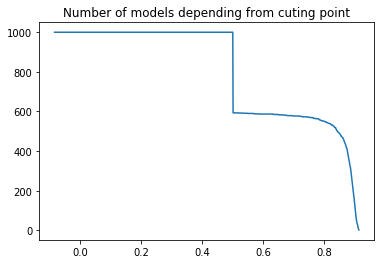

In [4]:
nr_of_models = [ j for j in range(1,1001)]
itera = 0 
for i in range(1,1001):
    nr_of_models[itera] = sum(data_res['mean_test_score'] >= max(data_res.mean_test_score)-i/1000)
    itera +=1 

    
    
plt.plot([ max(data_res.mean_test_score)-j/1000 for j in range(1,1001)],nr_of_models)

plt.title("Number of models depending from cuting point")

# Wykresy

In [96]:

import matplotlib.pyplot as plt 


Text(0.5, 1.0, 'Resoults distribution')

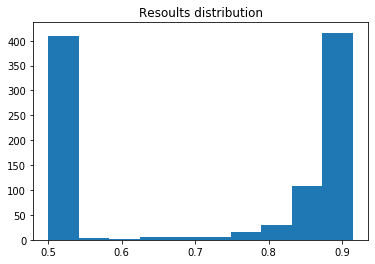

In [97]:

plt.hist(data_res.mean_test_score)
plt.title("Resoults distribution")

# Dalex 

In [98]:
params  = data_res.sort_values(by=["rank_test_score"]).head(200).reset_index().params
params = [params[i] for i in range(1,200,20)]# Do poprawy 

In [99]:
curr_mdl

Pipeline(memory=None,
         steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.03125, max_delta_step=0,
                               max_depth=1, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=4751,
                               n_jobs=1, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0.125, reg_lambda=16,
                               scale_pos_weight=1, subsample=0.8,
                               tree_method='exact', use_label_encoder=True,
                               validate_parameters=1, verbosi

In [100]:
curr_mdl.set_params(**params[i])

Pipeline(memory=None,
         steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.3, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.001953125, max_delta_step=0,
                               max_depth=15, min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=2751,
                               n_jobs=1, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0.00390625, reg_lambda=2,
                               scale_pos_weight=1, subsample=0.6,
                               tree_method='exact', use_label_encoder=True,
                               validate_parameters=1

In [101]:
params[0]

{'xgb__subsample': 0.4,
 'xgb__reg_lambda': 0.25,
 'xgb__reg_alpha': 1,
 'xgb__n_estimators': 4001,
 'xgb__min_child_weight': 1,
 'xgb__max_depth': 6,
 'xgb__learning_rate': 0.00390625,
 'xgb__colsample_bylevel': 0.8}

In [102]:
import warnings
import ast
import gc
warnings.warn("this will not show")
list_m = []
for i in range(len(params)):
    xgb_ = curr_mdl.set_params(**params[i]).fit(X_t,y)
    
    
    titanic_rf_exp = dx.Explainer(xgb_, 
                    X_t,y,label=f"XGB{i*20}")
    pd_rf_cat = titanic_rf_exp.model_parts()
    list_m.append(pd_rf_cat)
    gc.collect()


[00:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB0
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000341, mean = 0.189, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.261, mean = 0.00258, max = 0.669
  -> model_info        : package sklea

[00:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB160
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00871, mean = 0.189, max = 0.922
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.697, mean = 0.00271, max = 0.952
  -> model_info        : package skle

In [103]:
for i in list_m:
    i.plot()


In [104]:
gc.collect()
import warnings
warnings.warn("this will not show")
list_mo = []
for i in range(len(params)):
    xgb_ = curr_mdl.set_params(**params[i]).fit(X_t,y)
    
    
    titanic_rf_exp = dx.Explainer(xgb_, 
                    X_t,y,label=f"XGB{i*20}")
    pd_rf_cat = titanic_rf_exp.model_profile(N=50)
    list_mo.append(pd_rf_cat)
    gc.collect()



[00:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB0
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000341, mean = 0.189, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

  -> residuals         : min = -0.261, mean = 0.00258, max = 0.669
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.62it/s]


[00:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB20
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0061, mean = 0.19, max = 0.961
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

  -> residuals         : min = -0.426, mean = 0.00172, max = 0.884
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:20<00:00,  5.29it/s]


[00:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB40
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.01e-06, mean = 0.192, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.0377, mean = 1.64e-05, max = 0.0763
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:17<00:00,  6.34it/s]


[00:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB60
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000131, mean = 0.192, max = 0.998
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.173, mean = 0.000229, max = 0.424
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.46it/s]


[00:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB80
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.92e-06, mean = 0.192, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.0813, mean = -5.77e-06, max = 0.198
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:14<00:00,  7.21it/s]


[00:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB100
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.99e-06, mean = 0.192, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.0939, mean = 6.36e-06, max = 0.204
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.91it/s]


[00:46:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   3%|█▍                                                   | 3/108 [00:00<00:04, 24.01it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB120
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00117, mean = 0.191, max = 0.98
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.387, mean = 0.000844, max = 0.818
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:04<00:00, 23.92it/s]


[00:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB140
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00251, mean = 0.19, max = 0.976
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.693, mean = 0.00173, max = 0.968
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:08<00:00, 12.57it/s]


[00:47:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   2%|▉                                                    | 2/108 [00:00<00:05, 19.05it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB160
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00871, mean = 0.189, max = 0.922
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.697, mean = 0.00271, max = 0.952
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:06<00:00, 17.89it/s]


[00:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Calculating ceteris paribus:   0%|                                                             | 0/108 [00:00<?, ?it/s]

Preparation of a new explainer is initiated

  -> data              : 1068 rows 108 cols
  -> target variable   : 1068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB180
  -> predict function  : <function yhat_proba_default at 0x00000175F4DF91F8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0578, mean = 0.225, max = 0.846
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.694, mean = -0.0333, max = 0.876
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|███████████████████████████████████████████████████| 108/108 [00:12<00:00,  8.71it/s]


In [105]:
list_mo[0].plot(list_mo[1:5], variables = ["age","gscverbal_last","gscmotor_last","sodium_last_early","platelet_first_early","tempc_last"])

In [106]:
list_mo[6].plot(list_mo[6:], variables = ["age","gscverbal_last","gscmotor_last","sodium_last_early","platelet_first_early","tempc_last"])

In [107]:
list_mo[0].plot(list_mo[1:5], variables = ["spo2_min","hematocrit_first_ealry","wbc_last_early","sysbp_first",
                                           "resprate_first","urineoutput_sum"])

In [108]:
list_mo[6].plot(list_mo[6:], variables = ["spo2_min","hematocrit_first_ealry","wbc_last_early","sysbp_first",
                                           "resprate_first","urineoutput_sum"])